In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder , MinMaxScaler , StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

import math


from subprocess import check_output


In [2]:
def rmsle(y , y_pred):
    assert len(y) == len(y_pred)
    
    to_sum = np.average(np.square(np.log(y_pred+1)-np.log(y+1)))
    
    return np.sqrt(to_sum)

In [3]:
train = pd.read_csv('train.tsv' , sep='\t')
test = pd.read_csv('test.tsv' , sep='\t')



In [4]:
train.shape

(1482535, 8)

In [5]:
test.shape

(693359, 7)

In [6]:
#缺失值处理
def handle_missing(dataset):
    dataset.category_name.fillna(value='missing' , inplace=True)
    dataset.brand_name.fillna(value='missing',inplace=True)
    dataset.item_description.fillna(value = 'missing' , inplace=True)
    
    return dataset



In [7]:
train = handle_missing(train)
test = handle_missing(test)

In [11]:
le = LabelEncoder()

le.fit(np.hstack([train.category_name , test.category_name]))

LabelEncoder()

In [12]:
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

In [13]:
le.fit(np.hstack([train.brand_name , test.brand_name]))

train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)

In [14]:
del le

In [15]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity


In [16]:
#处理文本 非结构化
from keras.preprocessing.text import Tokenizer


raw_text = np.hstack([train.item_description.str.lower() ,train.name.str.lower()])

In [18]:
tok_raw = Tokenizer()

tok_raw.fit_on_texts(raw_text)

In [19]:
train['seq_item_description'] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test['seq_item_description'] = tok_raw.texts_to_sequences(test.item_description.str.lower())

train['seq_name'] = tok_raw.texts_to_sequences(train.name.str.lower())
test['seq_name'] = tok_raw.texts_to_sequences(test.name.str.lower())


In [20]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...,"[5, 9, 61, 178, 6528, 230, 3, 21, 166, 1085, 2...","[178, 2610, 14248]"
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity,"[807, 9, 6888, 11, 1997]","[4884, 104, 1032, 280]"


In [21]:
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))),
                       np.max(test.seq_name.apply(lambda x: len(x)))])

max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x))),
                                   np.max(test.seq_item_description.apply(lambda x: len(x)))])

print(max_name_seq , max_seq_item_description)

17 269


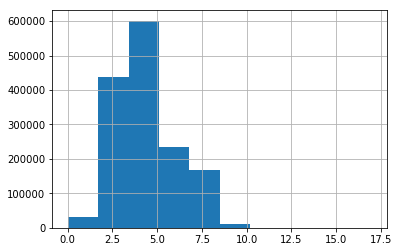

In [22]:
train.seq_name.apply(lambda x: len(x)).hist()

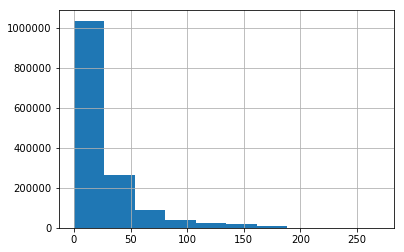

In [23]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [34]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

MAX_TEXT = np.max([np.max(train.seq_name.max()),
                  np.max(test.seq_name.max()),
                  np.max(train.seq_item_description.max()),
                  np.max(test.seq_item_description.max())])+2

MAX_CATEGORY= np.max([train.category_name.max(),
                     test.category_name.max()])+1

MAX_BRAND = np.max([train.brand_name.max() , test.brand_name.max()])+1

MAX_CONDITION = np.max([train.item_condition_id.max(),
                       test.item_condition_id.max()])+1

In [24]:
train.seq_name.max()

[259086, 3, 35, 209, 1725]

In [25]:
train['target'] = np.log(train.price + 1) #对数除偏

target_scaler = MinMaxScaler(feature_range=(-1,1))

train['target'] = target_scaler.fit_transform(train.target.reshape(-1,1))

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


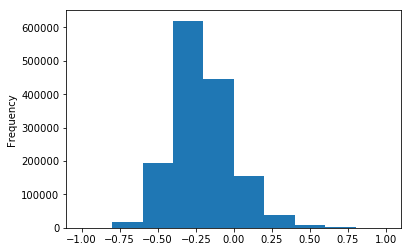

In [27]:
train.target.plot.hist()

In [36]:
dtrain , dvalid = train_test_split(train , random_state=123 ,
                                 train_size=0.99)

In [37]:
dtrain.shape

(1467709, 11)

In [38]:
dvalid.shape

(14826, 11)

In [31]:
from keras.preprocessing.sequence import pad_sequences


In [32]:
def get_keras_data(dataset):
    X={
        'name': pad_sequences(dataset.seq_name , maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description,maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category_name': np.array(dataset.category_name),
        'item_condition': np.array(dataset.item_condition_id),
        'num_vars': np.array(dataset[['shipping']])
    }
    
    return X

In [39]:
X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [40]:
from keras.layers import Input,Dropout ,Dense,BatchNormalization,Activation , concatenate,GRU,Embedding, Flatten , BatchNormalization
from keras.models import Model

from keras.callbacks import ModelCheckpoint , Callback , EarlyStopping

from keras import backend as K

In [41]:
def get_callbacks(filepath , patience=2):
    es = EarlyStopping('val_loss',patience=patience , mode='min')
    
    msave = ModelCheckpoint(filepath , save_best_only=True)
    
    return [es , msave]

def rmsle_cust(y_true , y_pred):
    first_log = K.log(K.clip(y_pred , K.epsilon(),None) + 1.0)
    second_log = K.log(K.clip(y_true , K.epsilon() , None) + 1.0)
    
    return K.sqrt(K.mean(K.square(first_log-second_log) , axis=-1))

In [42]:
def get_model():
    dr_r = 0.1
    
    name = Input(shape=[X_train['name'].shape[1]] , name='name')
    item_desc = Input(shape=[X_train['item_desc'].shape[1]],name='item_desc')
    brand_name = Input(shape=[1] , name='brand_name')
    category_name = Input(shape=[1] , name='category_name')
    item_condition = Input(shape=[1] , name='item_condition')
    num_vars = Input(shape=[X_train['num_vars'].shape[1]] , name='num_vars')
    
    
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

In [43]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (Inpu

In [44]:
BATCH_SIZE = 20000
epochs=5

model=get_model()

In [45]:
model.fit(X_train,dtrain.target , epochs=epochs,
         batch_size=BATCH_SIZE,
         validation_data=(X_valid , dvalid.target),
         verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 629s 429us/step - loss: 0.0312 - mean_absolute_error: 0.1335 - rmsle_cust: 0.0161 - val_loss: 0.0183 - val_mean_absolute_error: 0.1026 - val_rmsle_cust: 0.0136

In [46]:
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.487170888175


In [47]:
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
submission.to_csv("./submission_.csv", index=False)
#submission.price.hist()

In [49]:
submission.shape

(693359, 2)

In [54]:
len(X_test)

6